In [140]:
# Ignore cuDDa warning messages
import warnings
warnings.filterwarnings('ignore')

# Enable GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [100]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [101]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)

GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

In [ ]:
# Train the  model
model = DMJ.train_model_loop(epoch_batches=8, learning_rate=5e-4)
# model = DMJ.train_model(model, data_splits['x_train'], data_splits['y_train'], data_splits['x_val'], data_splits['y_val'], epochs=50, learning_rate=5e-5, gcn_matrix=DMJ.Normalized_Adjacency_Matrix)

In [ ]:
DMJ.save_model(tag='E2E_2LSTM_FThenT_Outputsize[None,1]_VariedLR_TFMSE_Dropout0.2_30D0DSwap')

In [ ]:
model_name = '02-15-2021--17--12-E2E_2LSTM_FThenT_Outputsize[None,1]_VariedLR_TFMSE_Dropout0.2_30D0DSwap-88Epochs-mse-Loss-32-HU-'
new_directory = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
GP.generate_validation_prediction_json(model_name, new_directory, sliding_window=300, neural_net_type='lstm', tag='_300window_valset')

In [ ]:
# GP.generate_validation_prediction_json(model_name, new_directory, sliding_window=30, neural_net_type='lstm', tag='_30window_valset')
directory = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/'
# directory = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
model = '02-16-2021--19--10-E2E-4LSTM-TTF-100.0ALPHA-[55,25,20]split-[None, 1]-sleepy-20Epochs-rlf-Loss-64-HU-_PM'
# GP.generate_model_diagnostics(directory + model, datablock_folder='./ignorable_data/datablocks/[55, 25, 20]_splits/')
GP.generate_model_diagnostics_given_sets(directory + model, DMJ.data_splits['x_val'], datablock_folder='./ignorable_data/datablocks/[55, 25, 20]_splits/', try_all_pred=False)
GP.generate_model_diagnostics_given_sets(directory + model, DMJ.data_splits['x_val'], datablock_folder='./ignorable_data/datablocks/[55, 25, 20]_splits/', try_all_pred=True)

In [ ]:
GP.compare_data_blocks('./ignorable_data/datablocks/[55, 25, 20]_splits/')

# Attempting to use the companies as batches

In [18]:
DMJ.XX_tf.shape
DMJ.YY_tf.shape

# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))

    if sum(new_splits) != total:
        new_splits[0] = new_splits[0] + (total - sum(new_splits))

    return new_splits


# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [79, 21]

x_train, x_test = tf.split(DMJ.XX_tf, split_windows(DMJ.XX_tf.shape[1], time_split),
                                  axis=1)
y_train, y_test = tf.split(DMJ.YY_tf, split_windows(DMJ.YY_tf.shape[1], time_split),
                                  axis=1)
rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(DMJ.YY_tf.shape[1], time_split),
                                     axis=1)

# Given our training data, let's split the data into two batches by company
company_split = [66, 33]

x_batch_t, x_batch_v = tf.split(x_train, split_windows(x_train.shape[0], company_split),
                                  axis=0)
y_batch_t, y_batch_v = tf.split(y_train, split_windows(y_train.shape[0], company_split),
                                  axis=0)
rr_batch_t, rr_batch_v = tf.split(rr_train, split_windows(rr_train.shape[0], company_split),
                                     axis=0)


In [22]:
print("X")
print(x_train.shape, x_test.shape)
print(x_batch_t.shape, x_batch_v.shape)
print("Y")
print(y_train.shape, y_test.shape)
print(y_batch_t.shape, y_batch_v.shape)
print("RR")
print(rr_batch_t.shape, rr_batch_v.shape)
print(' ')
print(x_train[:, 0, :].shape)

X
(881, 979, 5) (881, 260, 5)
(588, 979, 5) (293, 979, 5)
Y
(881, 979) (881, 260)
(588, 979) (293, 979)
RR
(588, 979) (293, 979)
 
(881, 5)


In [ ]:
# Creating an LSTM model

optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )

input_seq = keras.Input(shape=(x_batch_t.shape[1], x_batch_t.shape[2]))

# Create a function for the Tensorflow implementation of Tensorflow 2
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

hidden_units = 32
activation = leaky_relu

x = LSTM(hidden_units, return_sequences=True, activation=activation, dropout=0.5, recurrent_dropout=0.5)(input_seq)
x = LSTM(hidden_units, return_sequences=False, activation=activation, dropout=0.5, recurrent_dropout=0.5)(x)
x = Dense(1, activation=activation)(x)
model = tf.keras.Model(inputs=[input_seq], outputs=x)
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
model.summary()

In [ ]:
inputs_train = x_batch_t
train_labels = y_batch_t

inputs_val = x_batch_v
val_labels = y_batch_v

history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train.shape[0]),
                              epochs=10, validation_data=(inputs_val, val_labels))

In [ ]:
# Trained in Google Colab, datablocks will be generated here

In [ ]:
pred_dir = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/"
pred_file = '02-16-2021--07--32-E2E-3LSTM-TTF-0ALPHA-[55,25,20]split-[None, 1]output-30Epochs-rlf-Loss-32-HU-_PM'
GP.generate_model_diagnostics(pred_dir + pred_file, datablock_folder='./ignorable_data/datablocks/')
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_test, datablock_folder='./ignorable_data/datablocks/')

In [10]:
import matplotlib.pyplot as plt
print(GP.test_obj.shape)
print(x_test.shape)

n = 480
r = 1
for i in range(r):
    print(f'{i+n*r} ', end='')
    plt.plot(GP.test_obj[:, i+n*r])
    plt.plot(x_test[i+n*r, :, 0])

AttributeError: 'NoneType' object has no attribute 'shape'

In [102]:
import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# x = tf.keras.layers.ZeroPadding1D(padding=(1,0))(DMJ.data_splits['y_val'])
# # x = tf.concat(tf.zeros([880, 10], tf.float32), DMJ.data_splits['y_val'])
# print(x.shape)
# print(x[1, 0])
z = tf.zeros([881, 20], tf.float32)
x = tf.concat([z, DMJ.data_splits['y_val']], 1)
x.shape

In [ ]:
# # Proving that our RR labels make sense
# print(DMJ.data_splits['x_train'].shape)
# print(DMJ.data_splits['rr_train'].shape)

# # One company at time step 100
# print(DMJ.data_splits['x_train'][87, 30, 0])
# # One company at time step 101
# print(DMJ.data_splits['x_train'][87, 31, 0])

# # So if a model was able to see timesteps 0-100, then we would want this as the prediction
# print(DMJ.data_splits['rr_train'][87, 30])

# print('Therefore, RR_train is a successful label of X_train')

# # One company at time step 100
# print(DMJ.data_splits['x_train'][87, 30, 0])
# print(DMJ.data_splits['x_train'][87, 31, 0])
# # One company at time step 101
# print(DMJ.data_splits['y_train'][87, 30])


# print('Therefore, y_train is a successful label of x_train')
# # Proving that our RR labels make sense
# print(DMJ.data_splits['x_val'].shape)
# print(DMJ.data_splits['rr_val'].shape)

# What if we split the data into time batches ourselves and trained them?

In [103]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

# one_x = DMJ.XX_tf[0:2, :, :]
# one_y = DMJ.YY_tf[0:2, :]
one_x = DMJ.XX_tf
one_y = DMJ.YY_tf
one_x = DMJ.XX_tf[0:-1, :, :]
one_y = DMJ.YY_tf[0:-1, :]

# # Given a dataset, let's section off a fifth of the data to be used for testing purposes
# time_split = [1000, 239,]
# x_train, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
#                                   axis=1)
# y_train, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
#                                   axis=1)
# rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
#                                      axis=1)

# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [90, 710, 239, 199]
time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
x_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
x_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# y_train = y_train[:, -1]
# y_val = y_val[:, -1]

# # Once we have the data partitioned, let's split it into 8 sets of 125
# batch_splits = [1]*8
# # Create a list of 8 different time batches
# x_train_batches = []
# x_train_batches.append(tf.split(x_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# x_train_batches = [item for sublist in x_train_batches for item in sublist]

# y_train_batches = []
# y_train_batches.append(tf.split(y_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# y_train_batches = [item for sublist in y_train_batches for item in sublist]

# # Lets try truncating the values for the labels to only be the final value
# for i in range(len(y_train_batches)):
#     y_train_batches[i] = y_train_batches[i][:, -1]

# print(x_train[0, -1, 0])

# print(rr_train[0, -1])

# print(x_val[0, 0, 0])
# print(y_train[0, -1])
# for set in [x_train, x_g, x_val, x_test]:
print(x_val.shape)
print(x_train.shape)

(879, 309, 5)
(879, 309, 5)


In [ ]:
# Creating an LSTM model

optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )
# Assuming all time steps are the same size, we can just use the first item to determine input shape
input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

# Create a function for the Tensorflow implementation of Tensorflow 2
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

hidden_units = 64
activation = leaky_relu
do = 0
x = LSTM(hidden_units, activation=activation, dropout=do, return_sequences=True)(input_seq)
# x = tf.keras.layers.RepeatVector(x_train_batches[0].shape[1])(x)
# x = LSTM(hidden_units, activation=activation, dropout=do)(x)
x = Dense(1, activation=activation)(x)
model = tf.keras.Model(inputs=[input_seq], outputs=x)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

# model = Sequential()
# model.add(LSTM(hidden_units, activation=activation, input_shape=(x_train_batches[0].shape[1], x_train_batches[0].shape[2])))
# model.add(Dense(1, activation=activation))
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()
losses = []

In [ ]:
inputs_train = x_train
train_labels = y_train

inputs_val = x_val
val_labels = y_val


# int(inputs_train.shape[0])
history = model.fit(inputs_train, train_labels, batch_size=1,
                              epochs=1, validation_data=(inputs_val, val_labels))

for h in history.history['val_loss']:
    losses.append(h)
plt.plot(losses)

In [ ]:
# import random
# losses = []

# # Train over different time series in quick succession in random order
# items = list(range(len(x_train_batches)))
# random.shuffle(items)
# for i in items:
#     print(i)
#     inputs_train = x_train_batches[i]
#     train_labels = y_train_batches[i]

# #     inputs_val = x_batch_v
# #     val_labels = y_batch_v

# #     history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train.shape[0]),
# #                                   epochs=10, validation_data=(inputs_val, val_labels))
#     history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train.shape[0]),
#                                   epochs=3)
#     for h in history.history['loss']:
#         losses.append(h)
    
# avg_losses.append(np.mean(losses))
# print(avg_losses[-1])
# plt.plot(avg_losses)

In [ ]:
DMJ.model = model
DMJ.model_name = "2-20-21-1_LSTM_[25,25,20]_NoMasking_NoDropout_1Epoch_ReturnSeqTrue_1BatchSize"
DMJ.save_model()

In [15]:
# model_name = "2-16-21-Seq1LSTM-F-64HU-[800,239,200]split-full_y"
new_dir = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
# GP.generate_validation_prediction_json_SplitBatch_nofeat(model_name, new_directory, x_g, x_val, sliding_window=30)
# GP.generate_validation_prediction_json_SplitBatch_close_gap(model_name, new_directory, x_g, x_val, sliding_window=30)
model_name = '2-20-21-1_LSTM_[25,25,20]_NoMasking_NoDropout_1Epoch_ReturnSeqTrue_1BatchSize'
# model_dir = './ignorable_data/models/[55, 25, 20]_split'
# model_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models'
model_dir = './ignorable_data/models/[55, 25, 20]_split'
past = x_train
future = x_val
# new_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
sliding_window = x_val.shape[1]
# sliding_window = 10
window = [1, 250, 125, 60, 30, 10, 5, 500]
window = [15, 20, 25]
window = [sliding_window]
for w in window:
    GP.generate_predictions(model_name, model_dir, past, future, new_dir, w)
# GP.generate_validation_prediction_json_SplitBatch(model_name, new_dir, x_g, x_val, sliding_window=sliding_window)


Loading Model: '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1ALPHA309win_309past_309fut'


OSError: SavedModel file does not exist at: ./ignorable_data/models/[55, 25, 20]_split/2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1ALPHA309win_309past_309fut/{saved_model.pbtxt|saved_model.pb}

In [ ]:
model_name = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
model_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models'
GP.generate_dot_file(model_name, model_dir, 'lstm')

In [118]:
import os
p_file_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE309win_309past_309fut'
p_file_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits'
# p_file_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
future = x_val
new_dir = './ignorable_data/datablocks/[55, 25, 20]_splits/'
close_gap = False

use_argmin = False
yesterday_pred = False
GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)

for root, dirs, files in os.walk(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND\ignorable_data\datablocks\[55, 25, 20]_splits'):
    for filename in files:
#         GP.generate_prediction_results(filename, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
        GP.add_daily_value_to_datablock(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_daily_value_to_datablock_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_cumulative_return_ratio_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        None


# use_argmin = True
# yesterday_pred = False
# GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
# # GP.generate_model_diagnostics_given_sets(p_file_dir + f'/{p_file_name}', future, datablock_folder=new_dir, try_all_pred=False)

700 

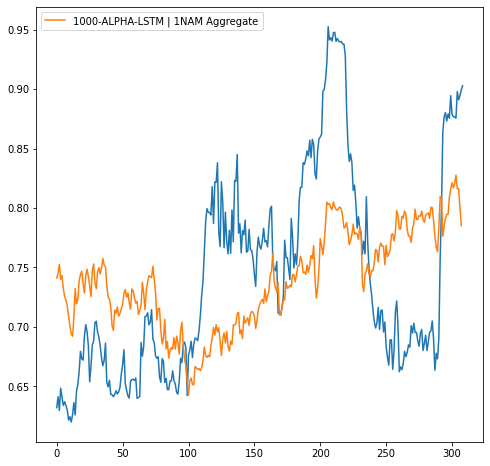

In [138]:
# n = 597
# n = 488
# n = 161
# n = 561
# n = 440
# n = 200
# # Argmin
# n = 780

# n = 876
# n = 110
# n = 420
r = 1

# n=0
# n=322
# n=328
n=700

fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_ylim([0,1])

time = tf.concat([x_train, x_val, x_test], axis=1)

# ax = fig.add_subplot()
for i in range(r):
    print(f'{i+n*r} ', end='')
#     ax.plot(time[i+n*r, :, 0])
    ax.plot(x_val[i+n*r, :, 0])
#     ax.plot(E[:, i+n*r], label='Just_RankLoss')
    
#     ax.plot(A[:, i+n*r], label='1000-ALPHA-LSTM')
    ax.plot(B[:, i+n*r], label='1000-ALPHA-LSTM | 1NAM Aggregate')
#     ax.plot(C[:, i+n*r], label='1000 Alpha 1DenseNam')
#     ax.plot(D[:, i+n*r], label='1000 Alpha 1DenseNam Full Train')
#     ax.plot(E[:, i+n*r], label='1Alpha - 0.1DropOut')
#     ax.plot(F[:, i+n*r], label='1000Alpha - 0.1DropOut')
#     ax.plot(G[:, i+n*r], label='ReturnSeqStep0')
#     ax.plot(H[:, i+n*r], label='1000Alpha - 1NAMAGG')
#     ax.plot(I[:, i+n*r], label='0.5Drop')
#     ax.plot(J[:, i+n*r], label='250')
#     ax.plot(K[:, i+n*r], label='1Batch-16Epochs')
    ax.legend()
# Orange
# Green
# Red
# Purple
# Brown

# fig, ax = plt.subplots(figsize=(16, 8))
# # ax.set_ylim([-0.2,0.3])
# # time = tf.concat([x_train, x_val], axis=1)
# # ax.plot(time[n, :, 0])
# # ax.plot(rr_val[n, :])
# # fig, ax = plt.subplots(figsize=(16, 8))
# # ax.plot(J[:, i+n*r], label='0.5Drop')
# ax.plot(H[:, 2], label='1000Alpha - 1NAMAGG')
# ax.plot(H[:, 4], label='1000Alpha - 1NAMAGG')
# # ax.plot(H[:, i+3*r], label='1000Alpha - 1NAMAGG')
# # ax.plot(I[:, i+9*r], label='1000Alpha - 1NAMAGG')

In [131]:
# pred_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version/'
pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
A = GP.test_obj

# pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
B = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1DenseGCN_TFMSE309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
C = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1DenseGCN_TFMSE_FullTrain309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
D = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_0.1Dropout_60Epoch_80BatchSize_1ALPHA_D309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
E = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_0.1Dropout_250Epoch_80BatchSize_1000ALPHA_D309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
F = GP.test_obj

pred_file = '2-19-21-1_LSTM_[25,25,20]_NoMasking_NoDropout_625Epoch_ReturnSeqTrue309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
G = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
H = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE_nym309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
I = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_RR_Labels309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
J = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_16Epoch_1BatchSize_IncreasedVariedLR309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
K = GP.test_obj
# ##################################################################################################################

# pred_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/'
# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# A = GP.test_obj

# # pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
# pred_file = '02-17-2021--07--37-1LSTM-F-1ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# B = GP.test_obj

# pred_file = '02-17-2021--07--54-1LSTM-F-10.0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# C = GP.test_obj

# pred_file = '02-17-2021--08--11-1LSTM-F-100.0ALPHA-[55,25,20]split-[None, 1]-30Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# D = GP.test_obj

# pred_file = '02-17-2021--08--29-1LSTM-F-1000.0ALPHA-[55,25,20]split-[None, 1]-20Epochs-rlf-Loss-64-HU-'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# E = GP.test_obj

Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions
Have Predictions


In [ ]:
GP.generate_predictions

In [ ]:
pred_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/'
pred_file = '02-17-2021--07--37-1LSTM-F-1ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, None)
B = GP.test_obj

In [ ]:
# pred_dir = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/"
pred_dir = r".\ignorable_data\prediction_results\[55, 25, 20]_splits/"
pred_file = '2-17-21-Seq1LSTM-F-64HU-[90,710,239,199]split-truncated_y_90win'
# GP.generate_model_diagnostics(pred_dir + pred_file, datablock_folder='./ignorable_data/datablocks/')
GP.generate_model_diagnostics_given_sets_close_gap(pred_dir + pred_file, x_val, datablock_folder='./ignorable_data/datablocks/', try_all_pred=False)

In [139]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

interactive(children=(Text(value='', description='Search', placeholder='Tag'), Output()), _dom_classes=('widge…

In [ ]:
test = [1]

In [ ]:
test[-1]

In [52]:
print(tf.constant([[1,1,1],[1,1,1],[1,1,1]]))

A = tf.constant([[[1,2,3],[4,5,6],[7,8,9],[7,8,9]]
             ,[[1,1,1],[1,1,1],[1,1,1],[7,8,9]],
             [[1,1,1],[1,1,1],[1,1,1],[7,8,9]]])
print(A)

B = tf.constant([[[1,2,3],[4,5,6],[7,8,9],[7,8,9]]
             ,[[1,1,1],[1,1,1],[1,1,1],[7,8,9]],
             [[1,1,1],[1,1,1],[1,1,1],[7,8,9]]])
# print(B)

# print(ones)

print(tf.matmul(A[:, 0, :], ones))

tf.Tensor(
[[1 1 1]
 [1 1 1]
 [1 1 1]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[[1 2 3]
  [4 5 6]
  [7 8 9]
  [7 8 9]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [7 8 9]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [7 8 9]]], shape=(3, 4, 3), dtype=int32)
tf.Tensor(
[[[6 6 6]
  [3 3 3]
  [3 3 3]]

 [[6 6 6]
  [3 3 3]
  [3 3 3]]], shape=(2, 3, 3), dtype=int32)


In [65]:
A = tf.constant([[1,1,1],[2,2,2],[3,3,3]])
B = tf.constant([[4,4,4],[5,5,5],[6,6,6]])
print(A)
print(B)
tf.einsum('ij,ji->ij', A, B)

tf.Tensor(
[[1 1 1]
 [2 2 2]
 [3 3 3]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[4 4 4]
 [5 5 5]
 [6 6 6]], shape=(3, 3), dtype=int32)


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])>

In [66]:
tf.einsum('ij,jk->ik', A, B)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[15, 15, 15],
       [30, 30, 30],
       [45, 45, 45]])>

In [ ]:
'ntd,nd'